### LDA

In [149]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

speech = pd.read_excel('../../Data/Final/speech_df.xlsx', index_col = 0)
speech['date'] = pd.to_datetime(speech['date'])
speech.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,date,title,speaker,speech
0,2023-11-16,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp..."
1,2023-11-16,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...
2,2023-11-14,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...
3,2023-11-13,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c..."
4,2023-11-09,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...


In [150]:
stop_words = set(stopwords.words('english'))
processed_docs = [
    [re.sub(r'[^\w\s]', '', word) for word in word_tokenize(doc.lower()) if word not in stop_words]
    for doc in speech['speech']
]

In [151]:
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [152]:
lda_model = models.LdaModel(
    corpus, 
    num_topics = 3, 
    id2word = dictionary, 
    passes = 10,
    random_state = 42
)

In [153]:
speech['topic0_speech'] = 0
speech['topic1_speech'] = 0
speech['topic2_speech'] = 0

In [154]:
for doc_bow in range(len(corpus)):
    for i in lda_model.get_document_topics(corpus[doc_bow]) :
        if i[0] == 0 :
            speech.loc[speech.index[doc_bow], 'topic0_speech'] = i[1]
        elif i[0] == 1 :
            speech.loc[speech.index[doc_bow], 'topic1_speech'] = i[1]
        elif i[0] == 2 :
            speech.loc[speech.index[doc_bow], 'topic2_speech'] = i[1]

In [155]:
speech

,date,title,speaker,speech,topic0_speech,topic1_speech,topic2_speech
0,2023-11-16,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp...",0.999527,0.000000,0.000000
1,2023-11-16,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...,0.061144,0.926297,0.012559
2,2023-11-14,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...,0.999416,0.000000,0.000000
3,2023-11-13,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c...",0.367295,0.000000,0.630443
4,2023-11-09,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...,0.999316,0.000000,0.000000
...,...,...,...,...,...,...,...
1041,2006-02-24,The Benefits of Price Stability,Chairman Ben S. Bernanke,It is a great pleasure for me to return to Pr...,0.959311,0.040540,0.000000
1042,2006-02-23,"Globalization, Insurers, and Regulators: Share...","Vice Chairman Roger W. Ferguson, Jr.",I am honored to deliver the keynote address a...,0.083642,0.850228,0.066130
1043,2006-02-06,Remarks at ceremonial swearing-in by President...,Chairman Ben S. Bernanke,Good morning. I would like to begin by thanki...,0.391503,0.257848,0.350649
1044,2006-02-02,The Continuous Challenges of Risk Management,Governor Susan Schmidt Bies,I thank you for the invitation to speak today...,0.000000,0.753666,0.246121


In [156]:
speech.index = speech['date']

In [157]:
topic_score = speech.iloc[:,-3:]

In [158]:
topic_score = topic_score.resample('M').mean()

<Axes: xlabel='date'>

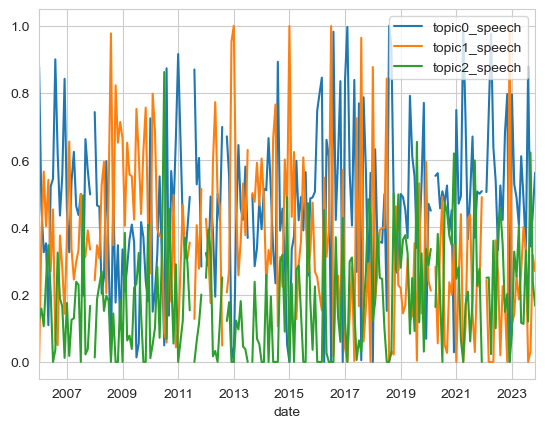

In [159]:
topic_score.plot()

In [160]:
# topic_score.to_csv('../../Data/Final/topic_score.csv')

In [165]:
lda_model.show_topics()

[(0,
  '0.162*"" + 0.011*"inflation" + 0.010*"policy" + 0.007*"rate" + 0.006*"economic" + 0.006*"monetary" + 0.006*"federal" + 0.006*"percent" + 0.005*"s" + 0.005*"economy"'),
 (1,
  '0.153*"" + 0.016*"financial" + 0.008*"banks" + 0.007*"capital" + 0.006*"market" + 0.006*"risk" + 0.005*"system" + 0.005*"federal" + 0.005*"bank" + 0.005*"reserve"'),
 (2,
  '0.134*"" + 0.012*"community" + 0.012*"banks" + 0.007*"bank" + 0.006*"federal" + 0.006*"reserve" + 0.006*"s" + 0.005*"financial" + 0.005*"communities" + 0.005*"credit"')]

#### PRESS

In [161]:
press = pd.read_excel('../../Data/Final/press_df.xlsx', index_col = 0)
press['date'] = pd.to_datetime(press['date'])
# press.drop('Unnamed: 0', axis = 1, inplace = True)
press.head()

,date,title,speech
0,2023-11-22,Agencies extend comment period on proposed ru...,Federal bank regulatory agencies announced to...
1,2023-11-21,Federal Reserve Board announces approval of ap...,The Federal Reserve Board on Tuesday announce...
2,2023-11-21,"Minutes of the Federal Open Market Committee, ...",The Federal Reserve on Tuesday released the m...
3,2023-11-21,Federal Reserve Board issues enforcement actio...,The Federal Reserve Board on Tuesday announce...
4,2023-11-17,Federal Reserve announces College Fed Challeng...,Harvard College won the 20th annual national ...


In [162]:
stop_words = set(stopwords.words('english'))
processed_docs = []
for doc in press['speech'] :
    try : 
        temp = []
        for word in word_tokenize(doc.lower()) :
            if word not in stop_words :
                temp.append(re.sub(r'[^\w\s]', '', word))
        processed_docs.append(temp)
    except : 
        processed_docs.append([])

In [163]:
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [167]:
lda_model = models.LdaModel(
    corpus, 
    num_topics = 3, 
    id2word = dictionary, 
    passes = 10,
    random_state = 42
)

In [168]:
press['topic0_press'] = 0
press['topic1_press'] = 0
press['topic2_press'] = 0

In [170]:
for doc_bow in range(len(corpus)):
    for i in lda_model.get_document_topics(corpus[doc_bow]) :
        if i[0] == 0 :
            press.loc[press.index[doc_bow], 'topic0_press'] = i[1]
        elif i[0] == 1 :
            press.loc[press.index[doc_bow], 'topic1_press'] = i[1]
        elif i[0] == 2 :
            press.loc[press.index[doc_bow], 'topic2_press'] = i[1]

In [171]:
press

,date,title,speech,topic0_press,topic1_press,topic2_press
0,2023-11-22,Agencies extend comment period on proposed ru...,Federal bank regulatory agencies announced to...,0.964764,0.025660,0.000000
1,2023-11-21,Federal Reserve Board announces approval of ap...,The Federal Reserve Board on Tuesday announce...,0.000000,0.984916,0.000000
2,2023-11-21,"Minutes of the Federal Open Market Committee, ...",The Federal Reserve on Tuesday released the m...,0.000000,0.988441,0.000000
3,2023-11-21,Federal Reserve Board issues enforcement actio...,The Federal Reserve Board on Tuesday announce...,0.000000,0.981959,0.000000
4,2023-11-17,Federal Reserve announces College Fed Challeng...,Harvard College won the 20th annual national ...,0.808127,0.030802,0.161071
...,...,...,...,...,...,...
4209,2006-01-10,Federal Bank and Thrift Agencies Propose Guida...,The federal bank and thrift regulatory agenci...,0.995064,0.000000,0.000000
4210,2006-01-10,Reserve Bank income and expense data and trans...,The Federal Reserve Board on Tuesday released...,0.020685,0.976629,0.000000
4211,2006-01-09,Consumer Advisory Council appointments for 2006,The Federal Reserve Board on Monday named ten...,0.973056,0.000000,0.026476
4212,2006-01-03,"Minutes of Federal Open Market Committee, Dece...",The Federal Reserve Board and the Federal Ope...,0.000000,0.987962,0.000000


In [172]:
press.index = press.date

In [173]:
press_topic_score = press.iloc[:,-3:]

In [174]:
press_topic_score = press_topic_score.resample('M').mean()

<Axes: xlabel='date'>

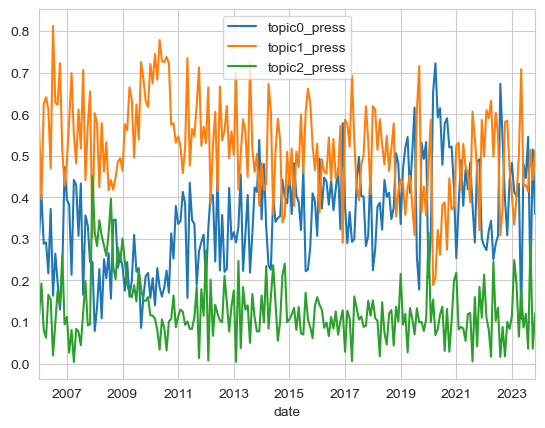

In [175]:
press_topic_score.plot()

In [176]:
lda_model.show_topics()

[(0,
  '0.142*"" + 0.016*"federal" + 0.012*"board" + 0.009*"reserve" + 0.009*"financial" + 0.007*"s" + 0.006*"agencies" + 0.006*"institutions" + 0.006*"bank" + 0.005*"capital"'),
 (1,
  '0.183*"" + 0.032*"reserve" + 0.028*"federal" + 0.028*"board" + 0.025*"bank" + 0.013*"announced" + 0.010*"attached" + 0.010*"s" + 0.009*"order" + 0.007*"agreement"'),
 (2,
  '0.175*"" + 0.011*"committee" + 0.010*"chairman" + 0.010*"percent" + 0.010*"federal" + 0.008*"inflation" + 0.007*"economic" + 0.007*"president" + 0.007*"term" + 0.007*"rate"')]

In [177]:
# press_topic_score.to_csv('../../Data/Final/press_topic_score.csv')